# Non-contextual embeddings
In this notebook we run the code for Word2Vec, Glove, and FastText for words extracted with TF-IDF in the previous notebook. Results of this notebook are not included in the final report.

In [4]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [5]:
TOP_N = 20
KEYS = { \
   "peopl": set(),
    "white": set(),
    "terror": set(),
    "feminazi": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "douchebag": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

In [6]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'peopl': {'peopl'},
 'white': {'white'},
 'terror': {'terror'},
 'feminazi': {'feminazi'},
 'women': {'woman', 'women'},
 'sexist': {'sexist'},
 'classy': {'classi', 'classy'},
 'sassy': {'sassi', 'sassy'},
 'nasty': {'nasti', 'nasty'},
 'stupid': {'stupid'},
 'shit': {'shit'},
 'idiot': {'idiot'},
 'trump': {'trump'},
 'nigga': {'nigga'},
 'giveaway': {'giveaway'},
 'game': {'game'},
 'enter': {'enter'},
 'guy': {'guy'},
 'good': {'good'},
 'gone': {'gone'},
 'world': {'world'},
 'fuck': {'fuck'},
 'little': {'littl', 'little'},
 'ass': {'as', 'ass'},
 'bitch': {'bitch'},
 'douchebag': {'douchebag'},
 'die': {'die'},
 'block': {'block'}}

In [7]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [8]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            print(key)
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [9]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [10]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [11]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    print(embedding_clusters.shape)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [12]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [14]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [15]:
model_gn = gensim.downloader.load('word2vec-google-news-300')

In [16]:
word_clusters_a, embedding_clusters = getSimilarWords(model_gn)

{'peopl'} -- people.i
{'peopl'} -- people
{'white'} -- whites
{'terror'} -- terrorism
{'terror'} -- terrorist
{'terror'} -- terrorists
{'terror'} -- terrorist attacks
{'terror'} -- terror
{'terror'} -- terrorist
{'terror'} -- terrorism
{'terror'} -- counter terrorism
{'terror'} -- terror plots
{'terror'} -- counterterrorism
{'terror'} -- antiterrorism
{'terror'} -- antiterror
{'terror'} -- terror suspects
{'terror'} -- homegrown terrorists
{'feminazi'} -- feminazis
{'women', 'woman'} -- women
{'women', 'woman'} -- womens
{'women', 'woman'} -- transwomen
{'women', 'woman'} -- women
{'women', 'woman'} -- woman
{'women', 'woman'} -- womens
{'women', 'woman'} -- women.the
{'women', 'woman'} -- women's
{'women', 'woman'} -- womenfolk
{'women', 'woman'} -- women's
{'women', 'woman'} -- businesswomen
{'women', 'woman'} -- womenâ € ™
{'women', 'woman'} -- workingwomen
{'sexist'} -- blatantly sexist
{'sexist'} -- racist sexist
{'sexist'} -- sexist
{'sexist'} -- sexists
{'sexist'} -- overtly sex

In [18]:
displayDF(word_clusters_a)

,peopl,white,terror,feminazi,women,sexist,classy,sassy,nasty,stupid,shit,idiot,trump,nigga,giveaway,game,enter,guy,good,gone,world,fuck,little,ass,bitch,douchebag,die,block
0,peop,black,al_Qaeda,commie_pinko,men,misogynistic,stylish,spunky,ugly,dumb,sh_*_t,moron,supersede,n_*_gga,give_aways,play,entry,dude,great,went,globe,f_*_ck,bit,butt,b_*_tch,douche_bag,perish,Exume_tried
1,ppl,blue,Al_Qaeda,whackjob,girls,sexism,elegant,sass,vicious,silly,crap,asshole,supercede,ni_**,giveways,match,participate,kid,bad,go,country,f_**_k,much,azz,ab_****,douche,dying,Kedvale_Avenue
2,peopel,brown,al_Qa'ida,women_libber,females,demeaning,lovely,brassy,unpleasant,idiotic,fucking,imbecile,prevail,n_*_ggas,raffle,matchup,leave,somebody,terrific,goes,continent,shit,wee_bit,shit,ab_*_tch,asshole,oil_Cvitanovich,Terroristic_threat
3,peple,colored,al_Qaida,male_chauvinist_pig,mothers,racist,tasteful,sexy,vile,foolish,sh_t,jackass,outweigh,homie,giveway,opener,join,fella,decent,fallen,nation,f_***,litte,dick,b_****,moron,kill,Hoyne_Avenue
4,poeple,wrote_Newitz,Qaeda,nerd_geek,ladies,misogynist,Stylish,perky,spiteful,ridiculous,fuckin,dumbass,trample,kanye,sweepstakes,matches,register,he'sa,nice,come,global,f_ck,everything'sa,hiney,whore,asshat,starve,Goguac_Street
5,nigerians,gray,Islamic_extremists,chauvinist_pig,husbands,vulgar,flashy,vampy,bad,dumb_dumb,sh_**,dolt,overshadow,motherf_*_cker,freebie,tournament,go,kidder,excellent,gotten,United_States,f_---,lot,dude,b_**_ch,dumbass,succumb,Briarwood_Drive
6,some1,browns_grays,jihadi,harpie,Men,blatant_sexism,nice,bitchy,bitter,moronic,fuck,stupid,dictate,**_ga,Raffle,playing,particpate,bloke,fantastic,done,globally,y'know,maybe,d_*_ck,ab_**_ch,jackass,Fatalistic_kids,Boxwood_Drive
7,peo_ple,blues_grays,al_Qa'eda,Andrea_Dworkin,female,ageist,fabulous,ditzy,wicked,idiots,f_*_cking,buffoon,reign_supreme,sh_*_t,Give_Away,league,engage,Mike'sa,better,moved,America,sh_*_t,tad,nads,bastard,dick,suffer,Avers_Avenue
8,peole,grays_browns,jihadist,libtard,male_counterparts,objectifies_women,gorgeous,sexpot,horrible,childish_immature,y'know,asshat,negate,brotha,Scavenger_hunt,scrimmages,send,involuntarily_yawned,solid,going,Europe,goddamn,litle,**_es,asshole,assclown,death,Woodale_Avenue
9,u_ppl,gorgeously_photographed_black,terrrorism,feminists,teenage_girls,politically_incorrect,sleek,saucy,viscious,daft,shyt,ignoramus,overridden,jay_z,Festive_Frenzy,scrimmage,partake,kid'sa,lousy,disappeared,planet,f_*_cking,smidgen,sh_*_t,whore_slut,twit,leaving_wispy_strands,South_Telshor_Boulevard


(28, 20, 300)


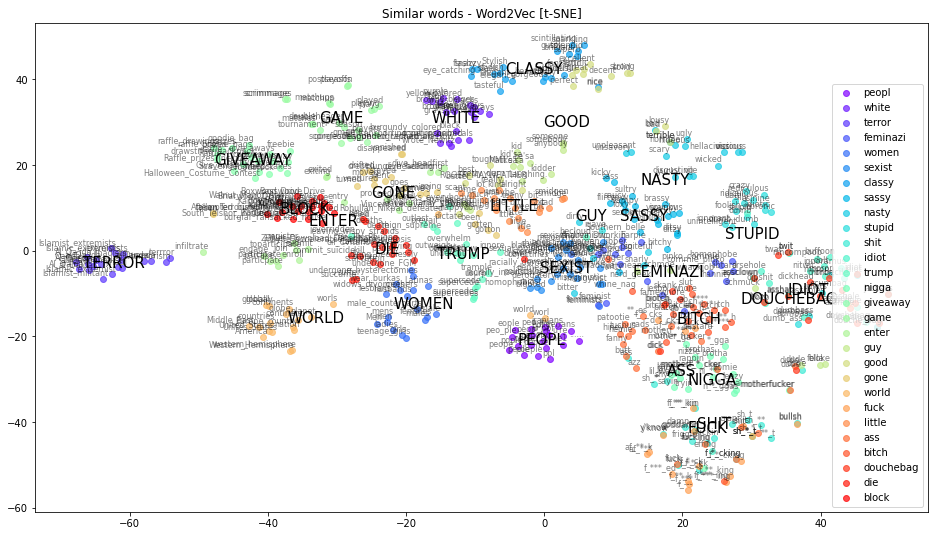

In [19]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - t-SNE.png")

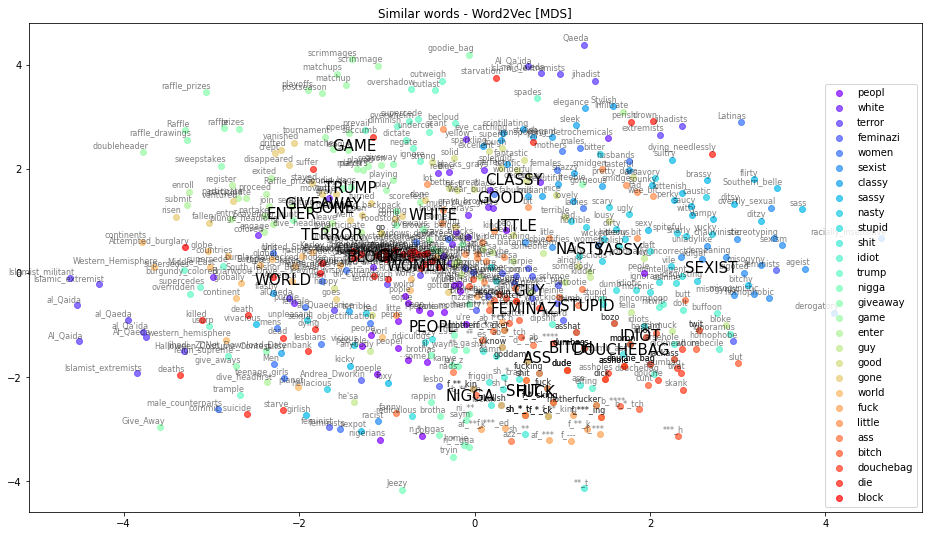

In [20]:
plotMDS("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS.png")

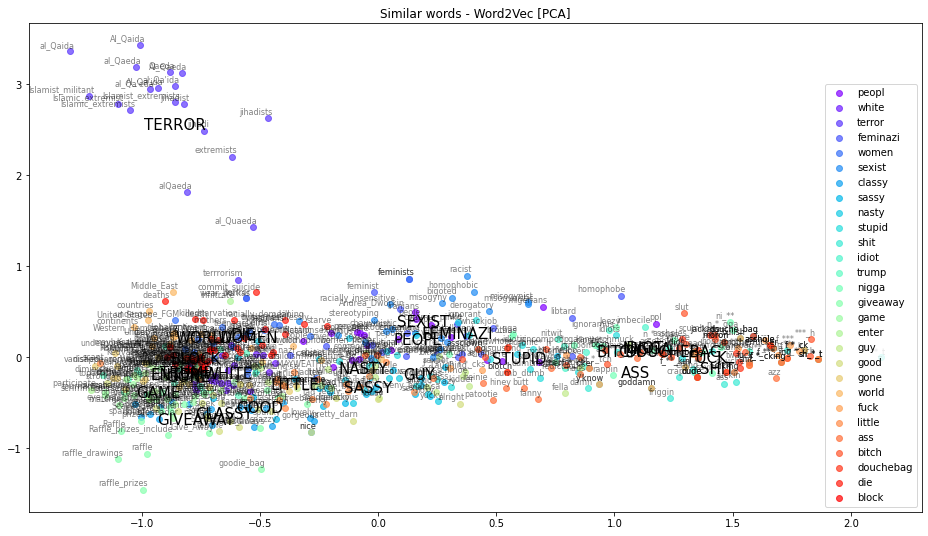

In [21]:
plotPCA("Similar words - Word2Vec [PCA]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - PCA.png")

### Clustering

In [23]:
avg_embeddings = dict()
for i, key in enumerate(FIXED_KEYS):
    avg_embeddings[key]= np.mean(np.array(embedding_clusters[i]), axis = 0)

### KMeans

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
dist_matrix = 1 - cosine_similarity(list(avg_embeddings.values()))

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_clusters = list(range(2,10))
avg = []
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(dist_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(dist_matrix, clusters)
    avg.append(silhouette_avg)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

2 clusters - silhouette: 0.4043654501438141
3 clusters - silhouette: 0.324262410402298
4 clusters - silhouette: 0.2959015965461731
5 clusters - silhouette: 0.29699522256851196
6 clusters - silhouette: 0.2891490161418915
7 clusters - silhouette: 0.28251293301582336
8 clusters - silhouette: 0.2524334192276001
9 clusters - silhouette: 0.2693548798561096


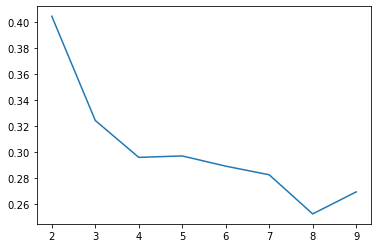

In [26]:
plt.plot(range_clusters, avg)

In [27]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(dist_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

Wall time: 31 ms
Clusters: [1, 2, 0, 1, 2, 2, 3, 2, 3, 1, 1, 1, 0, 1, 4, 4, 0, 1, 3, 0, 0, 1, 3, 1, 1, 1, 0, 4]


In [28]:
for i in range(num_clusters):
    print(f"Cluster {i}: {np.array(FIXED_KEYS)[np.where(i == np.array(clusters))[0]]}")

Cluster 0: ['terror' 'trump' 'enter' 'gone' 'world' 'die']
Cluster 1: ['peopl' 'feminazi' 'stupid' 'shit' 'idiot' 'nigga' 'guy' 'fuck' 'ass'
 'bitch' 'douchebag']
Cluster 2: ['white' 'women' 'sexist' 'sassy']
Cluster 3: ['classy' 'nasty' 'good' 'little']
Cluster 4: ['giveaway' 'game' 'block']


In [29]:
### Hierarhical clustering

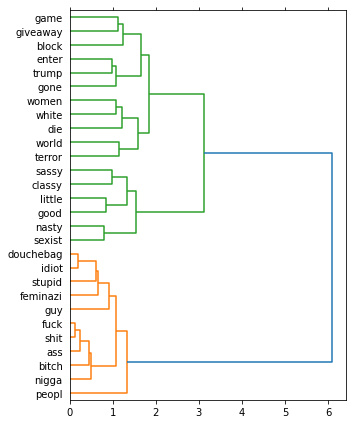

In [30]:
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist_matrix) 

fig, ax = plt.subplots(figsize=(5, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=FIXED_KEYS);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()

## glove

In [31]:
# stran dala: douchebag, feminazi

In [33]:
TOP_N = 20
KEYS = { \
   "people": set(),
    "white": set(),
    "terror": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'people': {'peopl', 'people'},
 'white': {'white'},
 'terror': {'terror'},
 'women': {'woman', 'women'},
 'sexist': {'sexist'},
 'classy': {'classi', 'classy'},
 'sassy': {'sassi', 'sassy'},
 'nasty': {'nasti', 'nasty'},
 'stupid': {'stupid'},
 'shit': {'shit'},
 'idiot': {'idiot'},
 'trump': {'trump'},
 'nigga': {'nigga'},
 'giveaway': {'giveaway'},
 'game': {'game'},
 'enter': {'enter'},
 'guy': {'guy'},
 'good': {'good'},
 'gone': {'gone'},
 'world': {'world'},
 'fuck': {'fuck'},
 'little': {'littl', 'little'},
 'ass': {'as', 'ass'},
 'bitch': {'bitch'},
 'die': {'die'},
 'block': {'block'}}

In [35]:
model_gn = gensim.downloader.load('glove-wiki-gigaword-300')

In [36]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'white'} -- whites
{'terror'} -- terrorist
{'terror'} -- terrorism
{'terror'} -- terrorists
{'terror'} -- counterterrorism
{'women', 'woman'} -- woman
{'nasti', 'nasty'} -- nastier
{'shit'} -- bullshit
{'idiot'} -- idiots
{'idiot'} -- idiotic
{'trump'} -- trumps
{'nigga'} -- niggas
{'giveaway'} -- giveaways
{'game'} -- games
{'enter'} -- entering
{'enter'} -- entered
{'enter'} -- enters
{'guy'} -- guys
{'world'} -- worlds
{'world'} -- worldwide
{'fuck'} -- fucking
{'fuck'} -- fucked
{'fuck'} -- motherfucker
{'as', 'ass'} -- asses
{'bitch'} -- bitchy
{'die'} -- died
{'die'} -- dies
{'block'} -- blocks
{'block'} -- blocking
{'block'} -- blocked


In [37]:
displayDF(word_clusters)

,people,white,terror,women,sexist,classy,sassy,nasty,stupid,shit,idiot,trump,nigga,giveaway,game,enter,guy,good,gone,world,fuck,little,ass,bitch,die,block
0,others,black,qaeda,men,homophobic,stylish,brassy,ugly,silly,fucking,fool,ivana,jigga,raffle,play,entry,thing,better,go,ever,shit,bit,arse,slut,dying,building
1,those,red,qaida,girls,racist,elegant,spunky,vicious,dumb,crap,imbecile,melania,bitch,bobblehead,players,allow,kid,really,going,time,wanna,much,bitch,fucking,dead,move
2,least,blue,attacks,female,misogynist,tasteful,sexy,brutish,foolish,fuck,blithering,casino,nyet,takeaway,player,permission,somebody,always,went,global,bitch,lot,fuck,bastard,death,prevent
3,many,house,extremists,male,misogynistic,sexy,perky,messy,ridiculous,suht,moron,nows,b/w,give-away,match,able,nice,you,just,event,expletive,too,shit,whore,kill,access
4,some,brown,suspects,mothers,demeaning,gutsy,saucy,unpleasant,idiotic,'cause,slob,knauss,motherfucker,clunkers,playing,into,really,well,goes,international,gonna,nothing,fucking,mommy,perish,stop
5,all,yellow,osama,athletes,bigoted,flashy,cheeky,bad,crazy,gonna,savant,hilton,aint,boondoggle,scoring,join,stuff,excellent,come,champion,'em,even,messed,daddy,der,house
6,them,pink,bombings,she,disrespectful,charming,streetwise,bitter,ignorant,bitch,babbling,ivanka,holdin,handout,played,allowed,'m,very,'ve,america,bleep,just,butt,fuck,sick,allow
7,thousands,colored,extremist,young,insensitive,wonderfully,vivacious,stuff,disgusting,kinda,stupid,resorts,allâh,promotional,season,participate,everybody,things,nothing,first,ass,few,momma,shit,und,push
8,hundreds,dark,mastermind,children,condescending,unpretentious,wisecracking,rude,irresponsible,damn,fucking,wynn,fuck,discounting,playoffs,permit,knows,think,anyway,championships,crap,but,expletive,ass,welt,floor
9,there,bush,plotting,people,disparaging,sleek,bitchy,scary,wrong,wannasathit,bastard,casinos,amrut,subsidy,playoff,must,man,way,maybe,events,gettin,kind,dumb,hey,deaths,proposed


(26, 20, 300)


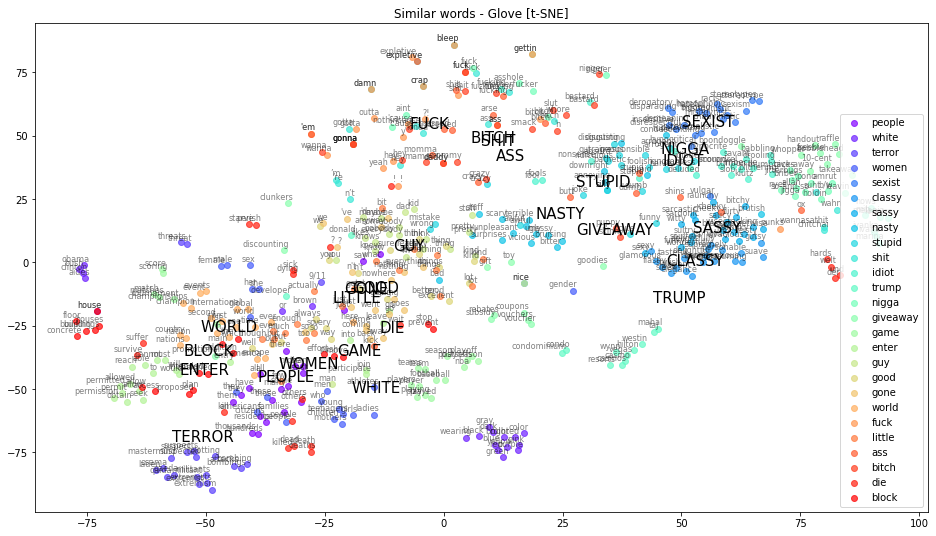

In [38]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE.png")

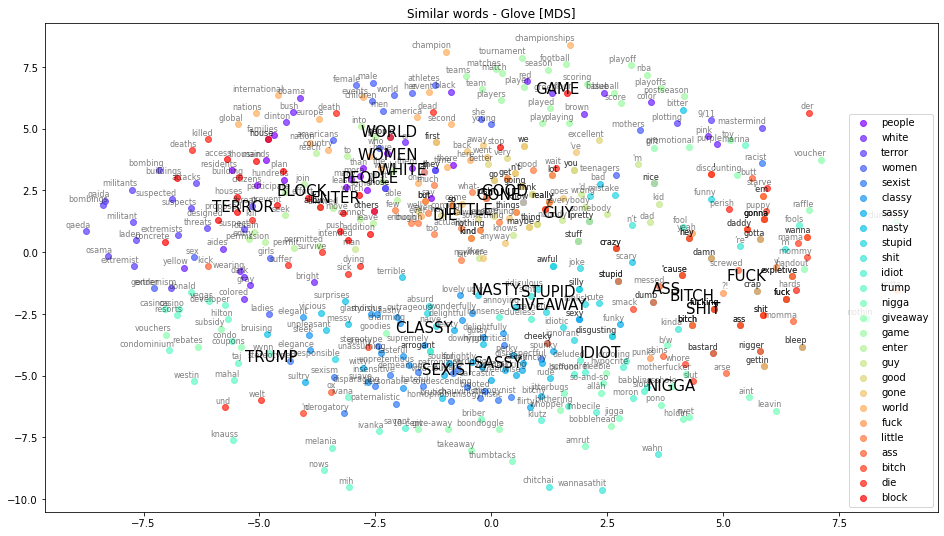

In [39]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS.png")

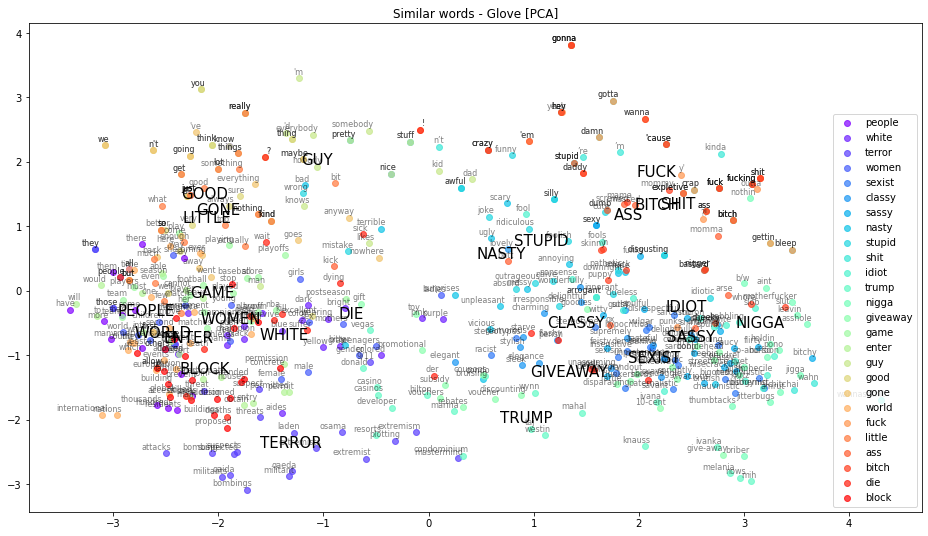

In [40]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA.png")

In [ ]:
## Clustering

In [41]:
avg_embeddings = dict()
for i, key in enumerate(FIXED_KEYS):
    avg_embeddings[key]= np.mean(np.array(embedding_clusters[i]), axis = 0)

In [42]:
### KMeans

In [43]:
dist_matrix = 1 - cosine_similarity(list(avg_embeddings.values()))
range_clusters = list(range(2,10))
avg = []
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(dist_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(dist_matrix, clusters)
    avg.append(silhouette_avg)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

2 clusters - silhouette: 0.4910459816455841
3 clusters - silhouette: 0.412577748298645
4 clusters - silhouette: 0.3211785554885864
5 clusters - silhouette: 0.3152727782726288
6 clusters - silhouette: 0.37870651483535767
7 clusters - silhouette: 0.3752214014530182
8 clusters - silhouette: 0.3468892276287079
9 clusters - silhouette: 0.3687278926372528


Text(0, 0.5, 'Silhouette score')

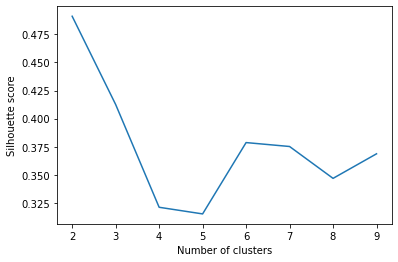

In [44]:
plt.plot(range_clusters, avg)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")


In [45]:
num_clusters = 6
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(dist_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

Wall time: 40.5 ms
Clusters: [2, 2, 2, 2, 5, 5, 5, 4, 4, 1, 5, 3, 5, 3, 2, 2, 0, 0, 0, 2, 1, 0, 1, 1, 0, 2]


In [46]:
for i in range(num_clusters):
    print(f"Cluster {i}: {np.array(FIXED_KEYS)[np.where(i == np.array(clusters))[0]]}")

Cluster 0: ['guy' 'good' 'gone' 'little' 'die']
Cluster 1: ['shit' 'fuck' 'ass' 'bitch']
Cluster 2: ['people' 'white' 'terror' 'women' 'game' 'enter' 'world' 'block']
Cluster 3: ['trump' 'giveaway']
Cluster 4: ['nasty' 'stupid']
Cluster 5: ['sexist' 'classy' 'sassy' 'idiot' 'nigga']


In [47]:
### Hierarchical

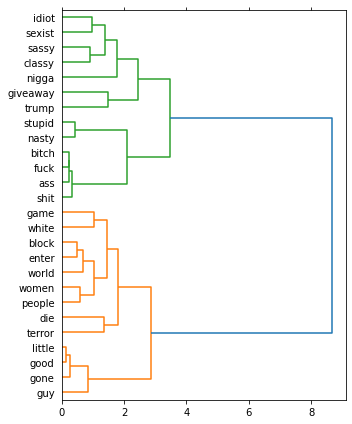

In [48]:
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist_matrix) 

fig, ax = plt.subplots(figsize=(5, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=FIXED_KEYS);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()

## fasttext

In [5]:
# Run first time only to download model
#import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')


In [ ]:
model_gn = load_facebook_vectors("cc.en.300.bin")

In [18]:
TOP_N = 30
KEYS = { \
   "people": set(),
    "white": set(),
    "terror": set(),
#    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
#    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
#    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "die": set(),
#    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'people': {'peopl', 'people'},
 'white': {'white'},
 'terror': {'terror'},
 'sexist': {'sexist'},
 'classy': {'classi', 'classy'},
 'sassy': {'sassi', 'sassy'},
 'nasty': {'nasti', 'nasty'},
 'stupid': {'stupid'},
 'shit': {'shit'},
 'idiot': {'idiot'},
 'trump': {'trump'},
 'nigga': {'nigga'},
 'giveaway': {'giveaway'},
 'enter': {'enter'},
 'guy': {'guy'},
 'good': {'good'},
 'gone': {'gone'},
 'fuck': {'fuck'},
 'little': {'littl', 'little'},
 'ass': {'as', 'ass'},
 'bitch': {'bitch'},
 'die': {'die'}}

In [19]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'people', 'peopl'} -- people.people
{'people', 'peopl'} -- people.those
{'people', 'peopl'} -- people.some
{'people', 'peopl'} -- people.many
{'people', 'peopl'} -- people  people
{'people', 'peopl'} -- people
{'people', 'peopl'} -- people.if
{'people', 'peopl'} -- people.i
{'people', 'peopl'} -- people.they
{'people', 'peopl'} -- people.so
{'people', 'peopl'} -- peoplee
{'people', 'peopl'} -- peoplel
{'people', 'peopl'} -- people.but
{'people', 'peopl'} -- people  they
{'people', 'peopl'} -- peoplen
{'people', 'peopl'} -- people.when
{'people', 'peopl'} -- peoples
{'people', 'peopl'} -- people  including
{'people', 'peopl'} -- people  who
{'people', 'peopl'} -- people people
{'people', 'peopl'} -- people.most
{'people', 'peopl'} -- people.you
{'people', 'peopl'} -- people.because
{'people', 'peopl'} -- people.now
{'people', 'peopl'} -- peopld
{'people', 'peopl'} -- peopler
{'people', 'peopl'} -- people.one
{'people', 'peopl'} -- ppeople
{'people', 'peopl'} -- people  and
{'people', '

{'guy'} -- guy.he
{'guy'} -- guy  he
{'guy'} -- guy.a
{'guy'} -- guy.
{'guy'} -- guy 
{'guy'} -- guy  
{'guy'} -- guy.now
{'guy'} -- guys
{'guy'} -- guy.that
{'guy'} -- guy.but
{'guy'} -- guy.the
{'guy'} -- guy.i
{'guy'} -- guy.so
{'guy'} -- guy.this
{'guy'} -- guy.what
{'guy'} -- guy.you
{'guy'} -- guy.and
{'guy'} -- guy.if
{'guy'} -- guy.when
{'guy'} -- guy.it
{'guy'} -- guy.as
{'guy'} -- guy.my
{'guy'} -- guy.in
{'guy'} -- guy.well
{'guy'} -- guy.there
{'guy'} -- guy.here
{'guy'} -- guy.we
{'guy'} --  guy
{'guy'} -- guyfriend
{'good'} -- good
{'good'} -- semi good
{'good'} -- good.good
{'good'} -- not so good
{'good'} -- good ish
{'good'} -- tgood
{'good'} -- good 
{'good'} -- good.great
{'good'} -- less than good
{'good'} -- agood
{'good'} -- good  a
{'good'} -- super good
{'good'} -- too.good
{'good'} -- better.good
{'good'} -- good.nice
{'good'} -- nice.good
{'good'} -- great.good
{'good'} -- good.this
{'good'} -- not good
{'good'} --  good
{'good'} -- good.a
{'good'} -- well.goo

In [20]:
displayDF(word_clusters)
#word_clusters

,people,white,terror,sexist,classy,sassy,nasty,stupid,shit,idiot,trump,nigga,giveaway,enter,guy,good,gone,fuck,little,ass,bitch,die
0,peope,black,terro,misogynistic,stylish,spunky,icky,dumb,crap,moron,drumpf,muthafucka,giveway,eneter,dude,bad,disappeared,fuk,bit,arse,biatch,dying
1,poeple,whtie,atrocity,misogynist,elegant,feisty,unpleasant,idiotic,sh1t,dumbass,donald,mothafucka,give-away,enetered,fella,great,vanished,shit,litttle,butt,biotch,perish
2,peole,blue,terrrorist,mysogynistic,chic,smart-mouthed,vile,moronic,shyte,imbecile,ivanka,n-gga,give-a-way,enetering,man,decent,went,bitch,liitle,azz,beotch,wither
3,peopel,balck,jihadist,mysoginistic,tasteful,saucy,horrid,silly,goddamn,dolt,hillary,muthafuckas,givaway,exiting,bloke,nice,been,dick,litle,dick,fucker,hards
4,folks,red,jihadi,chauvinistic,sylish,fiesty,yucky,asinine,shiz,dipshit,bannon,nigguh,givewaway,exit,dudes,excellent,dissappeared,fuuck,teensy,butt.I,beyotch,kill
5,those,yellow,terroism,mysoginist,sleek,sass,narsty,dumbass,shyt,dimwit,obama,tryna,Give-a-way,exited,knucklehead,goood,gotten,fuxk,wee,fucker,asshole,twenty-sided
6,individuals,grey,teror,mysogynist,elegent,flirty,ugly,stoopid,sh-t,nitwit,melania,niqqa,giveways,RaffleCopter,schmuck,ggod,dissapeared,fukc,lilttle,hiney,beeyotch,starve
7,poeople,gray,terroist,anti-feminist,chique,witty,horrible,dumb-ass,fucking,numbskull,ruffing,n-ggas,Give-away,participate,douchebag,terrific,forgotten,asshole,teeny,arse.,beyatch,shrivel
8,peoople,brown,suicide-bombing,anti-female,trendy,sexy,disgusting,stoooopid,fuckin,fucktard,clintons,bruh,giveawy,proceed,somebody,lousy,come,piss,tad,butt.,beeyatch,death
9,peopole,colored,extremism,misandrist,glamourous,vivacious,vicious,idiot,fuck,jackass,spades,mothafuckas,Giveway,leave,d-bag,better,done,phuck,lil,bitch,beeotch,sicken


(22, 30, 300)


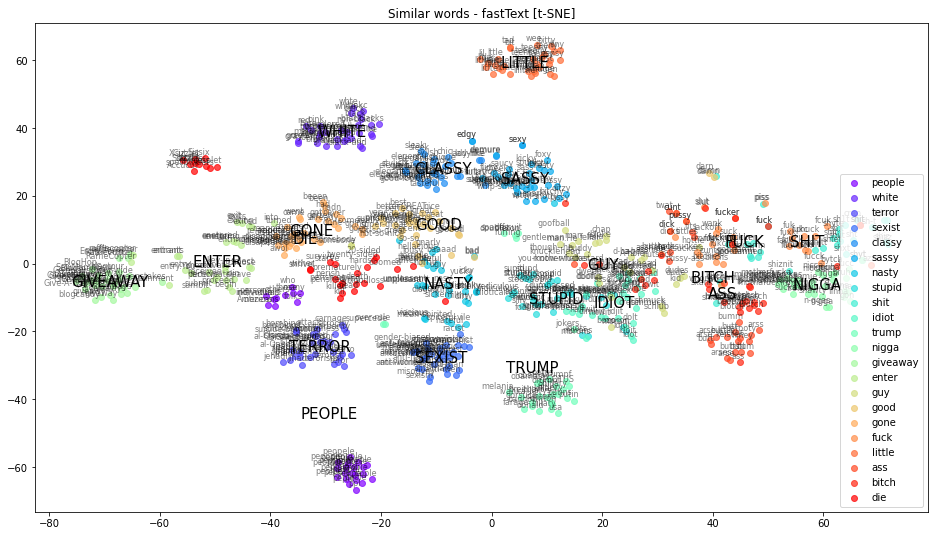

In [21]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - fastText - t-SNE.png")

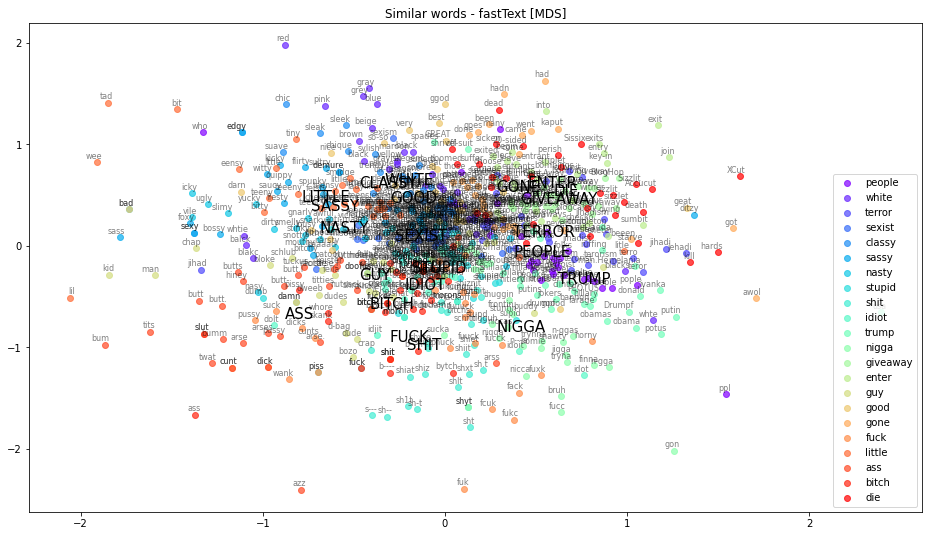

In [22]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters, "SimilarWords - fastText - MDS.png")

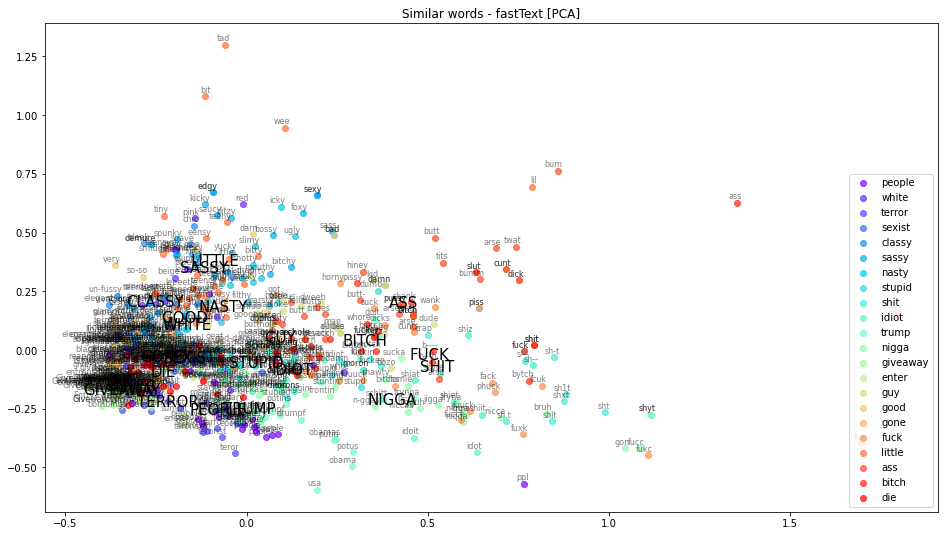

In [23]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters, "SimilarWords - fastText - PCA.png")

## Clustering

In [ ]:
avg_embeddings = dict()
for i, key in enumerate(FIXED_KEYS):
    avg_embeddings[key]= np.mean(np.array(embedding_clusters[i]), axis = 0)

### Kmeans

In [ ]:
dist_matrix = 1 - cosine_similarity(list(avg_embeddings.values()))
range_clusters = list(range(2,16))
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(dist_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(dist_matrix, clusters)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

In [ ]:
num_clusters = 9
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(dist_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

In [ ]:
for i in range(num_clusters):
    print(f"Cluster {i}: {np.array(FIXED_KEYS)[np.where(i == np.array(clusters))[0]]}")

In [ ]:
### Hierarchical clustering

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist_matrix) 

fig, ax = plt.subplots(figsize=(5, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=FIXED_KEYS);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()